# Horn Antenna Design for Hydrogen Line (1.42 GHz)

This notebook is for designing a horn antenna tuned for the hydrogen line frequency at 1.42 GHz.

## About the Project

The hydrogen line (21 cm line) is at 1420.405751 MHz and is used in radio astronomy to detect neutral hydrogen in space. This project will design a conical horn antenna to receive these signals. The outside will be 3D printed in PETG, while the inside will be covered in copper foil tape with conductive adhesive. PETG has a dielectric constant much different than air, so the conductive element should not be wrapped around the outside.

## Prerequisites

Before running this notebook, ensure you have:
1. OpenEMS installed on your system (see https://docs.openems.de/install.html)
2. Python dependencies installed: `pip install -r requirements.txt`

## References

- OpenEMS Documentation: https://docs.openems.de/
- OpenEMS Python Examples: https://github.com/thliebig/openEMS-Project
- PETG Properties: https://devel.lulzbot.com/filament/Rigid_Ink/PETG%20DATA%20SHEET.pdf
- Copper Tape With Conductive Adhesive: https://www.amazon.com/dp/B07QQHQMYD?th=1

## Imports

In [81]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.special import j1, jvp  # j1 for Bessel function, jvp for derivative
from scipy.optimize import brentq
import os
import sys

# Set up matplotlib for inline plotting
%matplotlib inline

print("Basic imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Basic imports successful!
NumPy version: 2.4.0
Matplotlib version: 3.10.8


In [82]:
# Try to import OpenEMS
# Note: This will fail if OpenEMS is not installed
try:
    from CSXCAD import CSXCAD
    from openEMS import openEMS
    from openEMS.physical_constants import C0, EPS0, MUE0
    print("✓ OpenEMS imported successfully!")
    openems_available = True
except ImportError as e:
    print("✗ OpenEMS not found. Please install OpenEMS first.")
    print(f"  Error: {e}")
    print("\nInstallation instructions:")
    print("  Visit: https://docs.openems.de/install.html")
    openems_available = False

✓ OpenEMS imported successfully!


## Design Parameters

Let's define the basic parameters for our **conical horn antenna** design.

In [83]:
# Hydrogen line frequency (21 cm line)
hydrogen_line_frequency_hz = 1420.405751768e6  # 1420.405751768 MHz in Hz (precise hydrogen line frequency via Wikipedia)
speed_of_light_meters_per_second = 299792458  # Speed of light in vacuum (m/s) - exact value
hydrogen_line_wavelength_meters = speed_of_light_meters_per_second / hydrogen_line_frequency_hz  # Wavelength in meters

print(f"Design frequency: {hydrogen_line_frequency_hz/1e9:.6f} GHz ({hydrogen_line_frequency_hz/1e6:.6f} MHz)")
print(f"Wavelength (λ): {hydrogen_line_wavelength_meters*1000:.2f} mm")

# Conical horn antenna parameters
# For circular waveguide: TE11 mode cutoff diameter ≈ 0.586λ
# waveguide_diameter_meters = 0.65 * hydrogen_line_wavelength_meters  # Slightly above cutoff for TE11 mode
desired_waveguide_cutoff_frequency_hz = 1.2 * 1e9 # 1.2 GHz
root_te11 = brentq(lambda x: jvp(1, x), 1.0, 3.0)
waveguide_diameter_meters = (root_te11 * speed_of_light_meters_per_second) / (np.pi * desired_waveguide_cutoff_frequency_hz) # TE11 mode cutoff diameter
cutoff_frequency_hz = root_te11 * speed_of_light_meters_per_second / (np.pi * waveguide_diameter_meters)

horn_length_meters = 3 * hydrogen_line_wavelength_meters            # Axial length of the horn
aperture_diameter_meters = 2.5 * hydrogen_line_wavelength_meters    # Output aperture diameter

# Calculate half-angle of the cone
flare_angle = np.arctan((aperture_diameter_meters - waveguide_diameter_meters) / (2 * horn_length_meters)) * 180 / np.pi

print(f"\nConical Horn Dimensions:")
print(f"  Waveguide diameter: {waveguide_diameter_meters*1000:.1f} mm ({waveguide_diameter_meters/hydrogen_line_wavelength_meters:.2f}λ)")
print(f"  Waveguide cutoff frequency: {cutoff_frequency_hz/1e6:.2f} MHz")
print(f"  Aperture diameter: {aperture_diameter_meters*1000:.1f} mm ({aperture_diameter_meters/hydrogen_line_wavelength_meters:.2f}λ)")
print(f"  Length: {horn_length_meters*1000:.1f} mm ({horn_length_meters/hydrogen_line_wavelength_meters:.1f}λ)")
print(f"  Flare angle: {flare_angle:.2f}°")

Design frequency: 1.420406 GHz (1420.405752 MHz)
Wavelength (λ): 211.06 mm

Conical Horn Dimensions:
  Waveguide diameter: 146.4 mm (0.69λ)
  Waveguide cutoff frequency: 1200.00 MHz
  Aperture diameter: 527.7 mm (2.50λ)
  Length: 633.2 mm (3.0λ)
  Flare angle: 16.75°


## Conical Horn Antenna Geometry Visualization

Let's visualize the conical horn antenna geometry before simulation.

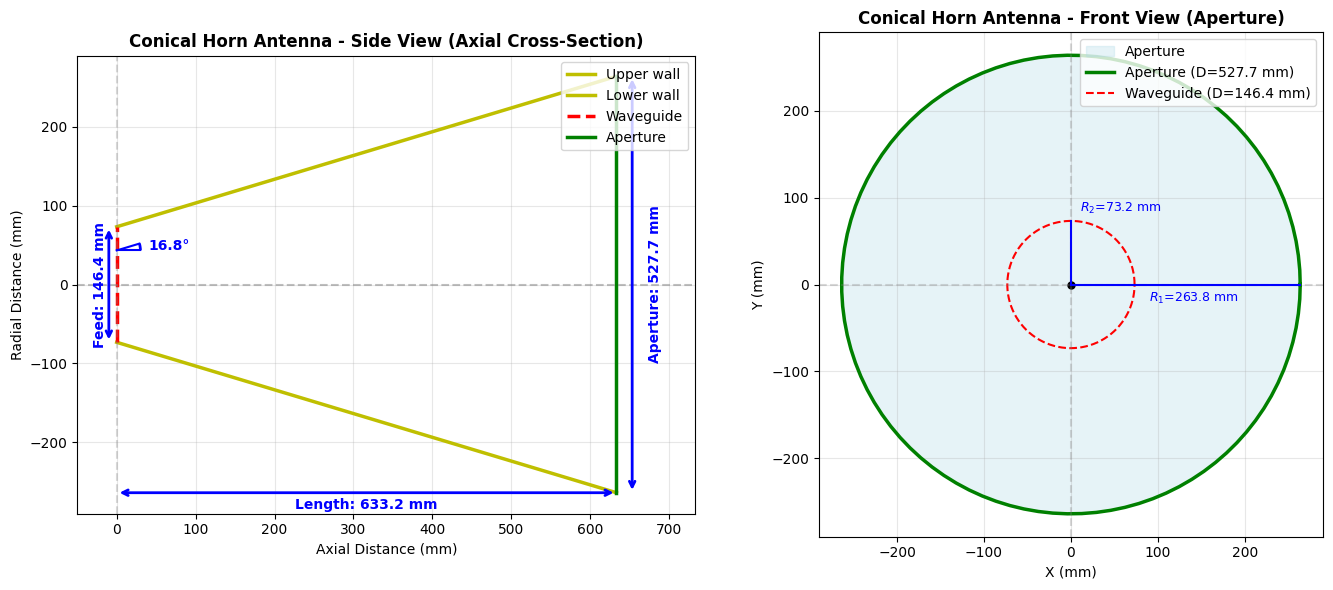


Conical Horn Specifications:
  Waveguide diameter: 146.4 mm
  Aperture diameter: 527.7 mm
  Axial length: 633.2 mm
  Flare angle: 16.75°
  Slant length: 661.3 mm


In [84]:
# Create visualization of the conical horn antenna
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Side view (cross-section through axis)
ax1.set_title('Conical Horn Antenna - Side View (Axial Cross-Section)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Axial Distance (mm)')
ax1.set_ylabel('Radial Distance (mm)')

# Draw conical horn outline
ax1.plot([0, horn_length_meters*1e3], [waveguide_diameter_meters/2 * 1e3, aperture_diameter_meters/2 * 1e3], 'y-', linewidth=2.5, label='Upper wall')
ax1.plot([0, horn_length_meters*1e3], [-waveguide_diameter_meters/2 * 1e3, -aperture_diameter_meters/2 * 1e3], 'y-', linewidth=2.5, label='Lower wall')
ax1.plot([0, 0], [-waveguide_diameter_meters/2 * 1e3, waveguide_diameter_meters/2 * 1e3], 'r--', linewidth=2.5, label='Waveguide')
ax1.plot([horn_length_meters*1e3, horn_length_meters*1e3], [-aperture_diameter_meters/2 * 1e3, aperture_diameter_meters/2 * 1e3], 'g-', linewidth=2.5, label='Aperture')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Add flare angle annotation with arc
arc_radius = 30  # mm, radius of the arc
arc_center_x = 0
arc_center_y = (waveguide_diameter_meters/2 * 1e3) - arc_radius
arc = patches.Arc((arc_center_x, arc_center_y), 2*arc_radius, 2*arc_radius, 
                  angle=0, theta1=0, theta2=flare_angle, 
                  color='blue', linewidth=2)
ax1.add_patch(arc)

# Add small lines at arc ends to indicate angle
line_length = 30
ax1.plot([arc_center_x, arc_center_x + line_length], [arc_center_y, arc_center_y], 'b-', linewidth=1.5)
end_x = arc_center_x + arc_radius * np.cos(np.radians(flare_angle))
end_y = arc_center_y + arc_radius * np.sin(np.radians(flare_angle))
ax1.plot([end_x - line_length*np.cos(np.radians(flare_angle)), end_x], 
         [end_y - line_length*np.sin(np.radians(flare_angle)), end_y], 
         'b-', linewidth=1.5)

# Add angle label
label_radius = arc_radius + 10
label_x = arc_center_x + label_radius * np.cos(np.radians(flare_angle/2))
label_y = arc_center_y + label_radius * np.sin(np.radians(flare_angle/2))
ax1.text(label_x, label_y, f'{flare_angle:.1f}°', color='blue', fontsize=10, 
         fontweight='bold', ha='left', va='center')

# Add horn length annotation
ax1.annotate('', xy=(0, -aperture_diameter_meters/2*1e3), 
             xytext=(horn_length_meters*1e3, -aperture_diameter_meters/2*1e3),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
ax1.text(horn_length_meters*1e3/2, -aperture_diameter_meters/2*1e3 - 20, 
         f'Length: {horn_length_meters*1e3:.1f} mm', color='blue', fontsize=10, 
         fontweight='bold', ha='center')

# Add aperture height annotation
ax1.annotate('', xy=(horn_length_meters*1e3 + 20, -aperture_diameter_meters/2*1e3), 
             xytext=(horn_length_meters*1e3 + 20, aperture_diameter_meters/2*1e3),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
ax1.text(horn_length_meters*1e3 + 40, 0, 
         f'Aperture: {aperture_diameter_meters*1e3:.1f} mm', color='blue', fontsize=10, 
         fontweight='bold', rotation=90, va='center')

# Add feed height annotation
ax1.annotate('', xy=(-10, -waveguide_diameter_meters/2*1e3), 
             xytext=(-10, waveguide_diameter_meters/2*1e3),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
ax1.text(-30, 0, 
         f'Feed: {waveguide_diameter_meters*1e3:.1f} mm', color='blue', fontsize=10, 
         fontweight='bold', rotation=90, va='center')

ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')
ax1.set_xlim(-50, horn_length_meters*1e3 + 100)
ax1.legend(loc='upper right')

# Front view (aperture view)
ax2.set_title('Conical Horn Antenna - Front View (Aperture)', fontsize=12, fontweight='bold')
ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')

# Draw circular aperture
theta = np.linspace(0, 2*np.pi, 100)
aperture_x = (aperture_diameter_meters/2) * np.cos(theta) * 1e3
aperture_y = (aperture_diameter_meters/2) * np.sin(theta) * 1e3
waveguide_x = (waveguide_diameter_meters/2) * np.cos(theta) * 1e3
waveguide_y = (waveguide_diameter_meters/2) * np.sin(theta) * 1e3

ax2.fill(aperture_x, aperture_y, color='lightblue', alpha=0.3, label='Aperture')
ax2.plot(aperture_x, aperture_y, 'g-', linewidth=2.5, label=f'Aperture (D={aperture_diameter_meters*1000:.1f} mm)')
ax2.plot(waveguide_x, waveguide_y, 'r--', linewidth=1.5, label=f'Waveguide (D={waveguide_diameter_meters*1000:.1f} mm)')

# Add center point and axis indicators
ax2.plot(0, 0, 'ko', markersize=5)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Add aperture radius annotation
ax2.plot([0, aperture_diameter_meters/2*1e3], [0, 0], 'b-', linewidth=1.5)
ax2.text(aperture_diameter_meters/4*1e3 + 10, -20, f'$R_1$={aperture_diameter_meters/2*1000:.1f} mm', 
         color='blue', fontsize=9, ha='center')

# Add waveguide radius annotation
ax2.plot([0, 0], [0, waveguide_diameter_meters/2*1e3], 'b-', linewidth=1.5)
ax2.text(10, waveguide_diameter_meters/2*1e3 + 10, f'$R_2$={waveguide_diameter_meters/2*1000:.1f} mm', 
         color='blue', fontsize=9, ha='left')

ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nConical Horn Specifications:")
print(f"  Waveguide diameter: {waveguide_diameter_meters*1000:.1f} mm")
print(f"  Aperture diameter: {aperture_diameter_meters*1000:.1f} mm")
print(f"  Axial length: {horn_length_meters*1000:.1f} mm")
print(f"  Flare angle: {flare_angle:.2f}°")
print(f"  Slant length: {np.sqrt(horn_length_meters**2 + ((aperture_diameter_meters-waveguide_diameter_meters)/2)**2)*1000:.1f} mm")


## Feed and Receiving Element Design

For the conical horn antenna, we need to design:
1. **Circular waveguide feed section** - provides the TE11 mode propagation
2. **Coaxial probe feed** - transitions from 50Ω coax to the circular waveguide
3. **Probe dimensions and positioning** - for optimal impedance matching

In [85]:
# Circular Waveguide Feed Parameters
# For TE11 mode (dominant mode in circular waveguide)

# TE11 cutoff frequency: fc = 1.841 * c / (π * D)
# where 1.841 is the first root of J1'(x) = 0

# We want hydrogen_line_frequency_hz > fc, so the waveguide operates above cutoff
# Typically operate at f/fc = 1.2 to 1.5 for good single-mode operation

root_te11 = brentq(lambda x: jvp(1, x), 1.0, 3.0)
cutoff_frequency = root_te11 * speed_of_light_meters_per_second / (np.pi * waveguide_diameter_meters)
guide_wavelength = hydrogen_line_wavelength_meters / np.sqrt(1 - (cutoff_frequency/hydrogen_line_frequency_hz)**2)

print("Circular Waveguide Feed (TE11 Mode):")
print("="*60)
print(f"Waveguide diameter: {waveguide_diameter_meters*1000:.2f} mm ({waveguide_diameter_meters*1e3/25.4:.3f} inches)")
print(f"Cutoff frequency (fc): {cutoff_frequency/1e9:.3f} GHz ({cutoff_frequency/1e6:.1f} MHz)")
print(f"Operating frequency (hydrogen_line_frequency_hz): {hydrogen_line_frequency_hz/1e9:.3f} GHz ({hydrogen_line_frequency_hz/1e6:.1f} MHz)")
print(f"hydrogen_line_frequency_hz/fc ratio: {hydrogen_line_frequency_hz/cutoff_frequency:.2f}")
print(f"Free-space wavelength (λ0): {hydrogen_line_wavelength_meters*1000:.2f} mm")
print(f"Guide wavelength (λg): {guide_wavelength*1000:.2f} mm")
print(f"λg/λ0 ratio: {guide_wavelength/hydrogen_line_wavelength_meters:.2f}")

# Check for single-mode operation
if 1.2 <= hydrogen_line_frequency_hz/cutoff_frequency <= 1.8:
    print(f"\n✓ Good single-mode operation (1.2 < hydrogen_line_frequency_hz/fc < 1.8)")
else:
    print(f"\n⚠ Warning: hydrogen_line_frequency_hz/fc = {hydrogen_line_frequency_hz/cutoff_frequency:.2f} may not be optimal")
    if hydrogen_line_frequency_hz/cutoff_frequency < 1.2:
        print("  Consider reducing waveguide diameter")
    else:
        print("  Risk of higher-order modes")

# Waveguide feed length (typically 0.5λg to 1λg for impedance matching)
# TODO: Adjust this for impedance matching.
# Most astronomical horn antennas use 0.20–0.35λg feeds.
guided_wavelength = 0.35 #λg
waveguide_length_meters = guide_wavelength * guided_wavelength
print(f"\nRecommended feed length: {waveguide_length_meters*1000:.1f} mm ({waveguide_length_meters/hydrogen_line_wavelength_meters:.2f}λ0, {guided_wavelength}λg)")

Circular Waveguide Feed (TE11 Mode):
Waveguide diameter: 146.42 mm (5.764 inches)
Cutoff frequency (fc): 1.200 GHz (1200.0 MHz)
Operating frequency (hydrogen_line_frequency_hz): 1.420 GHz (1420.4 MHz)
hydrogen_line_frequency_hz/fc ratio: 1.18
Free-space wavelength (λ0): 211.06 mm
Guide wavelength (λg): 394.48 mm
λg/λ0 ratio: 1.87

⚠ Warning: hydrogen_line_frequency_hz/fc = 1.18 may not be optimal
  Consider reducing waveguide diameter

Recommended feed length: 138.1 mm (0.65λ0, 0.35λg)


In [86]:
# Coaxial Probe Feed Design
# The probe couples electromagnetic energy from coax cable into the circular waveguide

# Standard coax impedance
Z0_coax = 50  # ohms (standard for RF systems)

# Waveguide impedance for TE11 mode
# Z_TE11 ≈ 502 * (λ0/λg) for circular waveguide
Z_waveguide = 502 * (hydrogen_line_wavelength_meters / guide_wavelength)

print("\nCoaxial Probe Feed Design:")
print("="*60)
print(f"Coax impedance (Z0): {Z0_coax} Ω")
print(f"Waveguide impedance (Z_TE11): {Z_waveguide:.1f} Ω")
print(f"Impedance ratio: {Z_waveguide/Z0_coax:.2f}")

# Probe length - critical for impedance matching
# The probe is a quarter-wave monopole antenna - uses FREE SPACE wavelength, not guide wavelength!
probe_length = hydrogen_line_wavelength_meters / 4  # λ0/4 for resonance

# Alternative probe lengths for different coupling
probe_length_short = hydrogen_line_wavelength_meters / 5  # Weaker coupling
probe_length_optimal = hydrogen_line_wavelength_meters / 4  # Optimal coupling (quarter-wave resonance)
probe_length_long = hydrogen_line_wavelength_meters / 3.5  # Stronger coupling

print(f"\nProbe Length Options (based on λ0, NOT λg):")
print(f"  Short coupling (λ0/5): {probe_length_short*1000:.1f} mm")
print(f"  Optimal coupling (λ0/4): {probe_length_optimal*1000:.1f} mm  ← Recommended")
print(f"  Strong coupling (λ0/3.5): {probe_length_long*1000:.1f} mm")

# Probe diameter - typically 1-3 mm for 1.4 GHz
# Should be << wavelength for thin monopole approximation
probe_diameter_min = 1.0e-3  # 1 mm
probe_diameter_typ = 1.5e-3  # 1.5 mm (typical)
probe_diameter_max = 2.5e-3  # 2.5 mm

print(f"\nProbe Diameter Options:")
print(f"  Minimum: {probe_diameter_min*1000:.1f} mm")
print(f"  Typical: {probe_diameter_typ*1000:.1f} mm  ← Recommended")
print(f"  Maximum: {probe_diameter_max*1000:.1f} mm")
print(f"  (Should be << λ0 = {hydrogen_line_wavelength_meters*1000:.1f} mm)")

# Probe position - distance from backshort
# Typically λg/4 from the shorted end for maximum E-field
backshort_distance = guide_wavelength / 4

print(f"\nProbe Position:")
print(f"  Distance from backshort: {backshort_distance*1000:.1f} mm (λg/4)")
print(f"  This positions the probe at the E-field maximum")

# Probe offset from center (for circular waveguide)
# For TE11 mode, maximum E-field is at approximately 0.4*radius from center
probe_offset = 0.4 * (waveguide_diameter_meters / 2)

print(f"  Radial offset from center: {probe_offset*1000:.1f} mm")
print(f"  (Approximately 0.4R for maximum TE11 coupling)")

# SMA connector dimensions (standard panel-mount SMA)
sma_mounting_hole = 6.5e-3  # 6.5 mm mounting hole diameter
sma_pin_diameter = 1.3e-3   # 1.3 mm center pin diameter (slightly larger than 0.51mm for mechanical strength)
sma_flange_diameter = 9.5e-3  # 9.5 mm flange diameter
print(f"\nSMA Connector (50Ω Panel-Mount):")
print(f"  Type: Standard SMA female panel-mount")
print(f"  Mounting hole: {sma_mounting_hole*1000:.1f} mm")
print(f"  Center pin diameter: {sma_pin_diameter*1000:.1f} mm")
print(f"  Impedance: 50 Ω")

# Store probe dimensions for later use
probe_params = {
    'sma_mounting_hole': sma_mounting_hole,
    'sma_pin_dia': sma_pin_diameter
}


print(f"\n✓ Probe parameters calculated and stored")


Coaxial Probe Feed Design:
Coax impedance (Z0): 50 Ω
Waveguide impedance (Z_TE11): 268.6 Ω
Impedance ratio: 5.37

Probe Length Options (based on λ0, NOT λg):
  Short coupling (λ0/5): 42.2 mm
  Optimal coupling (λ0/4): 52.8 mm  ← Recommended
  Strong coupling (λ0/3.5): 60.3 mm

Probe Diameter Options:
  Minimum: 1.0 mm
  Typical: 1.5 mm  ← Recommended
  Maximum: 2.5 mm
  (Should be << λ0 = 211.1 mm)

Probe Position:
  Distance from backshort: 98.6 mm (λg/4)
  This positions the probe at the E-field maximum
  Radial offset from center: 29.3 mm
  (Approximately 0.4R for maximum TE11 coupling)

SMA Connector (50Ω Panel-Mount):
  Type: Standard SMA female panel-mount
  Mounting hole: 6.5 mm
  Center pin diameter: 1.3 mm
  Impedance: 50 Ω

✓ Probe parameters calculated and stored


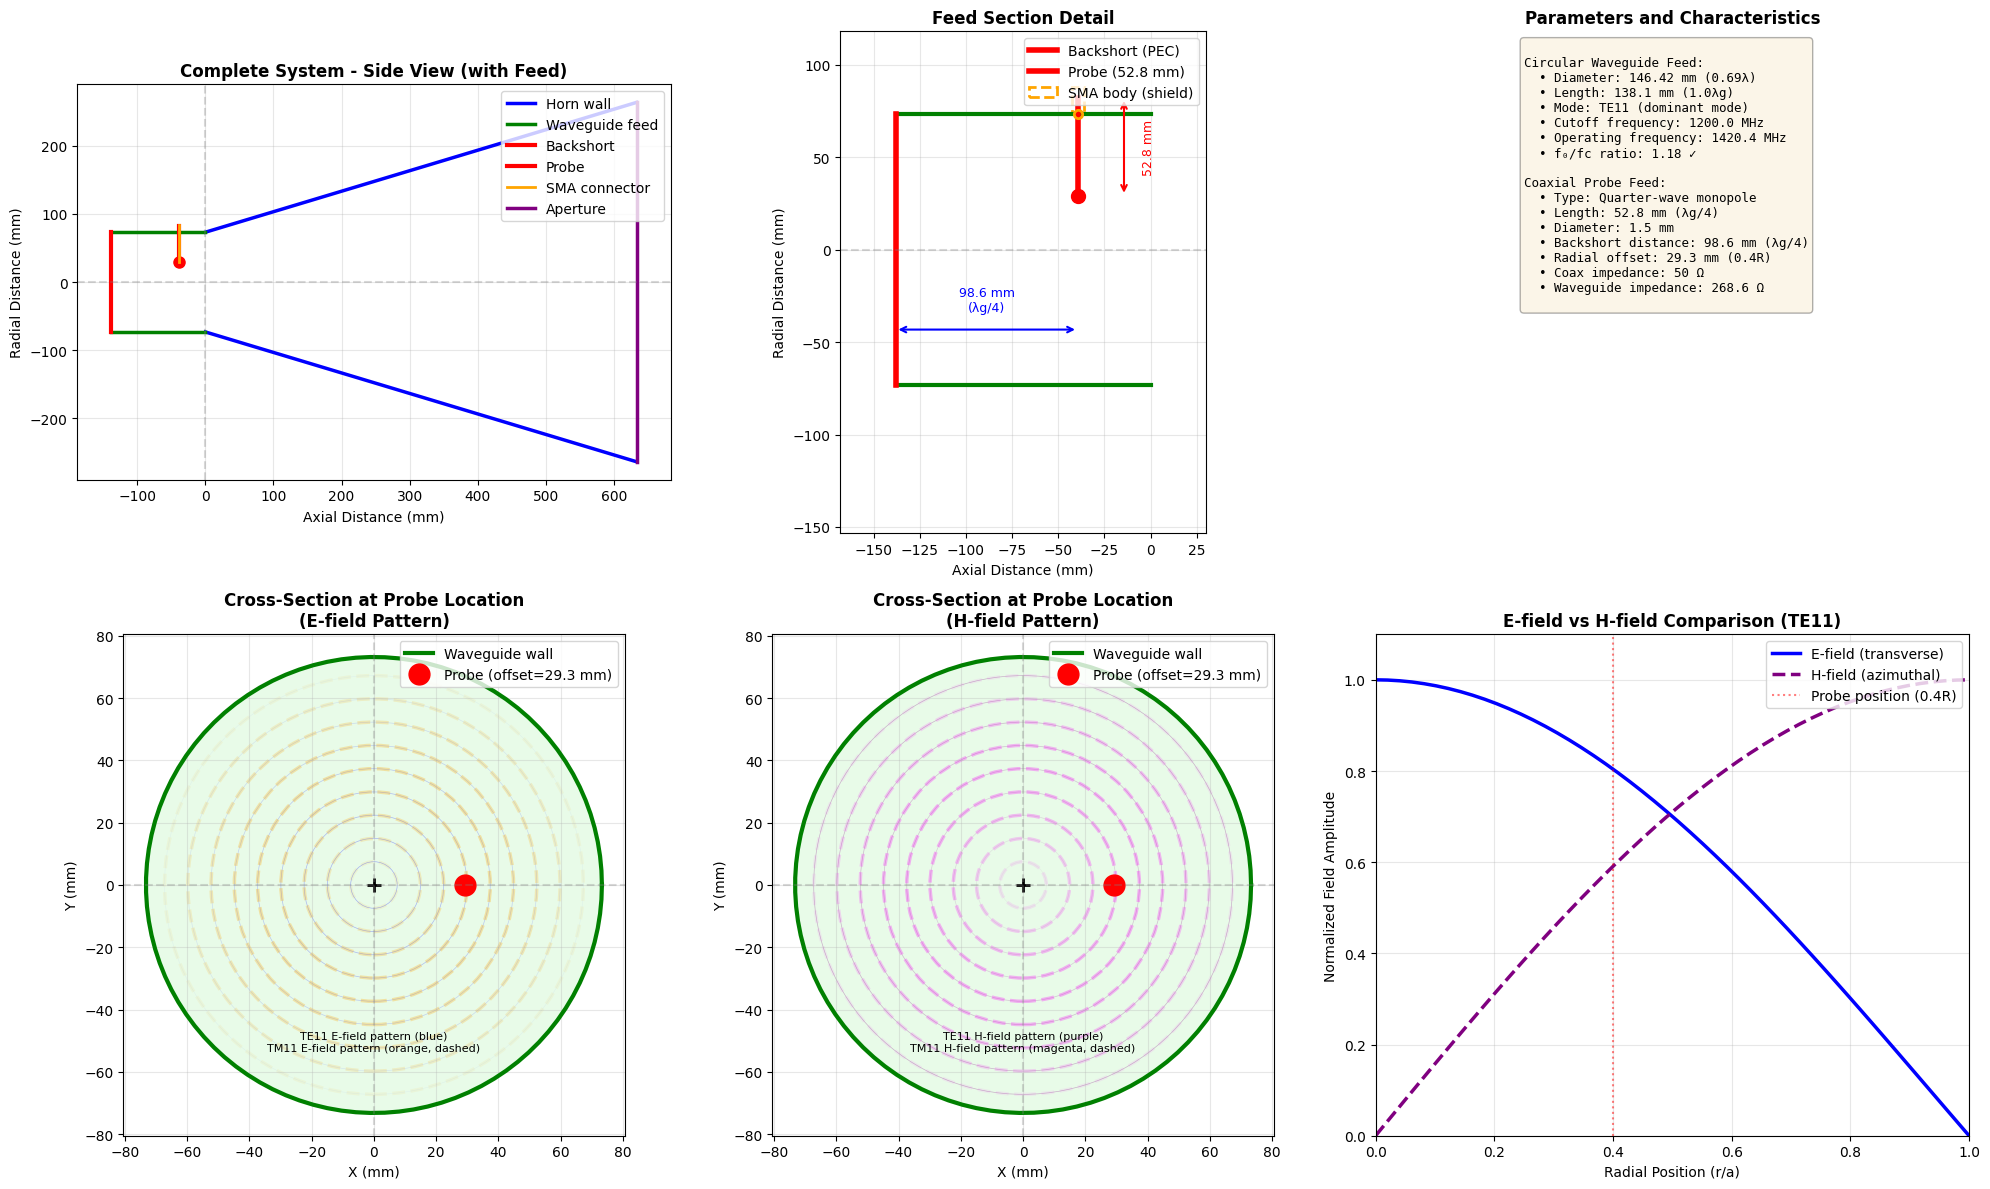

In [87]:
# Visualization of Feed Structure

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Side view - complete system with feed
ax1 = axes[0, 0]
ax1.set_title('Complete System - Side View (with Feed)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Axial Distance (mm)')
ax1.set_ylabel('Radial Distance (mm)')

# Horn outline
ax1.plot([0, horn_length_meters*1e3], [waveguide_diameter_meters/2 * 1e3, aperture_diameter_meters/2 * 1e3], 
         'b-', linewidth=2.5, label='Horn wall')
ax1.plot([0, horn_length_meters*1e3], [-waveguide_diameter_meters/2 * 1e3, -aperture_diameter_meters/2 * 1e3], 
         'b-', linewidth=2.5)

# Waveguide feed section (extends behind horn)
feed_start = -waveguide_length_meters*1e3
ax1.plot([feed_start, 0], [waveguide_diameter_meters/2 * 1e3, waveguide_diameter_meters/2 * 1e3], 
         'g-', linewidth=2.5, label='Waveguide feed')
ax1.plot([feed_start, 0], [-waveguide_diameter_meters/2 * 1e3, -waveguide_diameter_meters/2 * 1e3], 
         'g-', linewidth=2.5)

# Backshort (closed end)
ax1.plot([feed_start, feed_start], 
         [-waveguide_diameter_meters/2 * 1e3, waveguide_diameter_meters/2 * 1e3], 
         'r-', linewidth=3, label='Backshort')

# Probe position
probe_x = feed_start + backshort_distance*1e3
probe_y = probe_offset*1e3
ax1.plot([probe_x, probe_x], [probe_y, probe_y + probe_length*1e3], 
         'r-', linewidth=3, label='Probe')
ax1.plot(probe_x, probe_y, 'ro', markersize=8)

# SMA connector entry (perpendicular to waveguide, entering from outside on the probe side)
ax1.plot([probe_x, probe_x], [waveguide_diameter_meters/2 * 1e3 + 10, probe_y], 
         'orange', linewidth=2, label='SMA connector')

# Aperture
ax1.plot([horn_length_meters*1e3, horn_length_meters*1e3], 
         [-aperture_diameter_meters/2 * 1e3, aperture_diameter_meters/2 * 1e3], 
         'purple', linewidth=2.5, label='Aperture')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')
ax1.set_xlim(feed_start - 50, horn_length_meters*1e3 + 50)
ax1.set_aspect('equal')

# 2. Detailed feed section
ax2 = axes[0, 1]
ax2.set_title('Feed Section Detail', fontsize=12, fontweight='bold')
ax2.set_xlabel('Axial Distance (mm)')
ax2.set_ylabel('Radial Distance (mm)')

# Waveguide walls
ax2.plot([feed_start, 0], [waveguide_diameter_meters/2 * 1e3, waveguide_diameter_meters/2 * 1e3], 
         'g-', linewidth=3)
ax2.plot([feed_start, 0], [-waveguide_diameter_meters/2 * 1e3, -waveguide_diameter_meters/2 * 1e3], 
         'g-', linewidth=3)

# Backshort
ax2.plot([feed_start, feed_start], 
         [-waveguide_diameter_meters/2 * 1e3, waveguide_diameter_meters/2 * 1e3], 
         'r-', linewidth=4, label='Backshort (PEC)')

# Probe
ax2.plot([probe_x, probe_x], [probe_y, probe_y + probe_length*1e3], 
         'r-', linewidth=4, label=f'Probe ({probe_length*1e3:.1f} mm)')
ax2.plot(probe_x, probe_y, 'ro', markersize=10)

# SMA connector (entering from outside the waveguide on the probe side)
sma_entry_start = waveguide_diameter_meters/2 * 1e3 + 15  # Outside the waveguide
waveguide_wall_pos = waveguide_diameter_meters/2 * 1e3  # Waveguide wall position

# Center pin extends from outside, through wall, to probe tip
#ax2.plot([probe_x, probe_x], [sma_entry_start, probe_y], 
#         'orange', linewidth=3, label='SMA center pin')

# SMA body/shield only exists OUTSIDE the waveguide wall (terminates at wall)
ax2.add_patch(plt.Rectangle((probe_x - sma_mounting_hole/2*1e3, 
                             waveguide_wall_pos), 
                            sma_mounting_hole*1e3, 
                            sma_entry_start - waveguide_wall_pos,
                            fill=False, edgecolor='orange', linewidth=2, 
                            linestyle='--', label='SMA body (shield)'))

# Add a small circle at the wall to show where SMA body terminates (flange mount point)
ax2.plot(probe_x, waveguide_wall_pos, 'o', color='orange', markersize=6, 
         markerfacecolor='none', markeredgewidth=2)

# Annotations
ax2.annotate('', xy=(feed_start, -waveguide_diameter_meters/2*1e3 + 30), 
             xytext=(probe_x, -waveguide_diameter_meters/2*1e3 + 30),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=1.5))
ax2.text((feed_start + probe_x)/2, -waveguide_diameter_meters/2*1e3 + 40, 
         f'{backshort_distance*1e3:.1f} mm\n(λg/4)', ha='center', color='blue', fontsize=9)

ax2.annotate('', xy=(probe_x + 25, probe_y), 
             xytext=(probe_x + 25, probe_y + probe_length*1e3),
             arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
ax2.text(probe_x + 35, probe_y + probe_length*1e3/2, 
         f'{probe_length*1e3:.1f} mm', color='red', fontsize=9, rotation=90, va='center')

ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')
ax2.set_aspect('equal')
# Set explicit axis limits to show full feed section including SMA connector
ax2.set_xlim(feed_start - 30, 30)
ax2.set_ylim(-waveguide_diameter_meters/2*1e3 - 80, sma_entry_start + 30)

# 3. Cross-section at probe location - E-field
ax3 = axes[1, 0]
ax3.set_title('Cross-Section at Probe Location\n(E-field Pattern)', fontsize=12, fontweight='bold')
ax3.set_xlabel('X (mm)')
ax3.set_ylabel('Y (mm)')

# Waveguide circle
theta_wg = np.linspace(0, 2*np.pi, 100)
wg_x = (waveguide_diameter_meters/2) * np.cos(theta_wg) * 1e3
wg_y = (waveguide_diameter_meters/2) * np.sin(theta_wg) * 1e3
ax3.plot(wg_x, wg_y, 'g-', linewidth=3, label='Waveguide wall')
ax3.fill(wg_x, wg_y, color='lightgreen', alpha=0.2)

# Probe position
ax3.plot(probe_offset*1e3, 0, 'ro', markersize=15, label=f'Probe (offset={probe_offset*1e3:.1f} mm)')

# Probe circle
probe_circle = plt.Circle((probe_offset*1e3, 0), probe_diameter_typ/2*1e3, 
                          color='red', alpha=0.5)
ax3.add_patch(probe_circle)

# Center
ax3.plot(0, 0, 'k+', markersize=10, markeredgewidth=2)

# TODO: Really double check the math to calculate the transverse E and H field patterns.
# TE11 E-field pattern indication using proper Bessel function derivative J1'
r_pattern = np.linspace(0, waveguide_diameter_meters/2, 50)
# Proper TE11 pattern: E-field (transverse) ∝ J1'(p11 * r/a) where p11 = 1.841 (first root of J1'(x) = 0)
# jvp(1, x) returns the derivative J1'(x) directly as a scalar
x = 1.841 * r_pattern / (waveguide_diameter_meters/2)
E_pattern_TE11 = np.abs(jvp(1, x))
# Normalize for visualization
E_pattern_TE11 = E_pattern_TE11 / np.max(E_pattern_TE11) if np.max(E_pattern_TE11) > 0 else E_pattern_TE11
for i, r in enumerate(r_pattern[::5]):
    circle = plt.Circle((0, 0), r*1e3, fill=False, edgecolor='blue', 
                        alpha=0.3*E_pattern_TE11[i*5], linewidth=0.5)
    ax3.add_patch(circle)

# TM11 E-field pattern using proper Bessel function J1
# TM11 pattern: E-field ∝ J1(p'11 * r/a) where p'11 = 3.832 (first root of J1(x) = 0)
E_pattern_TM11 = np.abs(j1(3.832 * r_pattern / (waveguide_diameter_meters/2)))
# Normalize for visualization
E_pattern_TM11 = E_pattern_TM11 / np.max(E_pattern_TM11) if np.max(E_pattern_TM11) > 0 else E_pattern_TM11
for i, r in enumerate(r_pattern[::5]):
    circle = plt.Circle((0, 0), r*1e3, fill=False, edgecolor='orange', 
                        alpha=0.3*E_pattern_TM11[i*5], linewidth=2.5, linestyle='--')
    ax3.add_patch(circle)

ax3.text(0, -waveguide_diameter_meters/2*1e3 + 20, 'TE11 E-field pattern (blue)\nTM11 E-field pattern (orange, dashed)', 
         ha='center', fontsize=8, color='black')

ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')
ax3.legend(loc='upper right')

# 3b. Cross-section at probe location - H-field
ax3b = axes[1, 1]
ax3b.set_title('Cross-Section at Probe Location\n(H-field Pattern)', fontsize=12, fontweight='bold')
ax3b.set_xlabel('X (mm)')
ax3b.set_ylabel('Y (mm)')

# Waveguide circle
ax3b.plot(wg_x, wg_y, 'g-', linewidth=3, label='Waveguide wall')
ax3b.fill(wg_x, wg_y, color='lightgreen', alpha=0.2)

# Probe position
ax3b.plot(probe_offset*1e3, 0, 'ro', markersize=15, label=f'Probe (offset={probe_offset*1e3:.1f} mm)')

# Probe circle
probe_circle_h = plt.Circle((probe_offset*1e3, 0), probe_diameter_typ/2*1e3, 
                          color='red', alpha=0.5)
ax3b.add_patch(probe_circle_h)

# Center
ax3b.plot(0, 0, 'k+', markersize=10, markeredgewidth=2)

# For TE11 mode: H_z (longitudinal) ∝ J1(p11 * r/a) where p11 = 1.841
# This is different from E-field which uses J1' (the derivative)
H_pattern_TE11 = np.abs(j1(1.841 * r_pattern / (waveguide_diameter_meters/2)))
# Normalize for visualization
H_pattern_TE11 = H_pattern_TE11 / np.max(H_pattern_TE11) if np.max(H_pattern_TE11) > 0 else H_pattern_TE11
for i, r in enumerate(r_pattern[::5]):
    circle = plt.Circle((0, 0), r*1e3, fill=False, edgecolor='purple', 
                        alpha=0.3*H_pattern_TE11[i*5], linewidth=0.5)
    ax3b.add_patch(circle)

# TM11 H-field pattern using proper Bessel function J1
# For TM11 mode: H_phi ∝ J1(p'11 * r/a) where p'11 = 3.832
H_pattern_TM11 = np.abs(j1(3.832 * r_pattern / (waveguide_diameter_meters/2)))
# Normalize for visualization
H_pattern_TM11 = H_pattern_TM11 / np.max(H_pattern_TM11) if np.max(H_pattern_TM11) > 0 else H_pattern_TM11
for i, r in enumerate(r_pattern[::5]):
    circle = plt.Circle((0, 0), r*1e3, fill=False, edgecolor='magenta', 
                        alpha=0.3*H_pattern_TM11[i*5], linewidth=2.5, linestyle='--')
    ax3b.add_patch(circle)

ax3b.text(0, -waveguide_diameter_meters/2*1e3 + 20, 'TE11 H-field pattern (purple)\nTM11 H-field pattern (magenta, dashed)', 
         ha='center', fontsize=8, color='black')

ax3b.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax3b.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax3b.grid(True, alpha=0.3)
ax3b.set_aspect('equal')
ax3b.legend(loc='upper right')

# 4. Feed impedance matching diagram
ax4 = axes[0, 2]
ax4.set_title('Parameters and Characteristics', fontsize=12, fontweight='bold')
ax4.axis('off')

# Text description
info_text = f"""
Circular Waveguide Feed:
  • Diameter: {waveguide_diameter_meters*1000:.2f} mm ({waveguide_diameter_meters/hydrogen_line_wavelength_meters:.2f}λ)
  • Length: {waveguide_length_meters*1000:.1f} mm (1.0λg)
  • Mode: TE11 (dominant mode)
  • Cutoff frequency: {cutoff_frequency/1e6:.1f} MHz
  • Operating frequency: {hydrogen_line_frequency_hz/1e6:.1f} MHz
  • f₀/fc ratio: {hydrogen_line_frequency_hz/cutoff_frequency:.2f} ✓

Coaxial Probe Feed:
  • Type: Quarter-wave monopole
  • Length: {probe_length*1e3:.1f} mm (λg/4)
  • Diameter: {probe_diameter_typ*1e3:.1f} mm
  • Backshort distance: {backshort_distance*1e3:.1f} mm (λg/4)
  • Radial offset: {probe_offset*1e3:.1f} mm (0.4R)
  • Coax impedance: 50 Ω
  • Waveguide impedance: {Z_waveguide:.1f} Ω
"""

ax4.text(0.25, 0.98, info_text, transform=ax4.transAxes, 
         fontsize=9, verticalalignment='top', horizontalalignment='left', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 5. Field pattern comparison
ax5 = axes[1, 2]
ax5.set_title('E-field vs H-field Comparison (TE11)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Radial Position (r/a)')
ax5.set_ylabel('Normalized Field Amplitude')

r_normalized = r_pattern / (waveguide_diameter_meters/2)
ax5.plot(r_normalized, E_pattern_TE11, 'b-', linewidth=2.5, label='E-field (transverse)')
ax5.plot(r_normalized, H_pattern_TE11, 'purple', linewidth=2.5, label='H-field (azimuthal)', linestyle='--')
ax5.axvline(x=0.4, color='red', linestyle=':', alpha=0.5, label='Probe position (0.4R)')
ax5.grid(True, alpha=0.3)
ax5.legend(loc='upper right')
ax5.set_xlim(0, 1)
ax5.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()


## OpenEMS Feed Implementation

If OpenEMS is available, we can add the feed geometry to the simulation.

In [88]:
if openems_available:
    print("Adding feed structure to OpenEMS simulation...")
    
    # Convert to mm for OpenEMS
    feed_length_mm = waveguide_length_meters * 1e3
    waveguide_radius_mm = waveguide_diameter_meters * 1e3 / 2
    probe_length_mm = probe_length * 1e3
    probe_radius_mm = probe_diameter_typ * 1e3 / 2
    backshort_pos_mm = -feed_length_mm
    probe_pos_mm = backshort_pos_mm + backshort_distance * 1e3
    probe_offset_mm = probe_offset * 1e3
    
    print(f"\nFeed Geometry (in mm for OpenEMS):")
    print(f"  Waveguide radius: {waveguide_radius_mm:.2f} mm")
    print(f"  Feed length: {feed_length_mm:.1f} mm")
    print(f"  Backshort position: {backshort_pos_mm:.1f} mm")
    print(f"  Probe position (axial): {probe_pos_mm:.1f} mm")
    print(f"  Probe offset (radial): {probe_offset_mm:.2f} mm")
    print(f"  Probe length: {probe_length_mm:.1f} mm")
    print(f"  Probe radius: {probe_radius_mm:.2f} mm")
    
    # Add circular waveguide feed (cylinder)
    # Note: In a full implementation, use CSX.AddCylinder() with proper coordinates
    print("\n💡 OpenEMS Implementation Steps:")
    print("  1. Create circular waveguide using CSX.AddCylinder()")
    print("     - Start: [backshort, 0, 0]")
    print("     - Stop: [0, 0, 0]")
    print("     - Radius: waveguide_radius")
    print("  ")
    print("  2. Add backshort plane using CSX.AddBox()")
    print("     - Metal disc at backshort position")
    print("  ")
    print("  3. Add coaxial probe using CSX.AddCylinder()")
    print("     - Start: [probe_pos, probe_offset, -waveguide_radius - 10mm]")
    print("     - Stop: [probe_pos, probe_offset, probe_offset + probe_length]")
    print("     - Radius: probe_radius")
    print("  ")
    print("  4. Define lumped port at coax entry point")
    print("     - Use FDTD.AddLumpedPort() with 50Ω impedance")
    print("     - Excitation at probe base")
    print("  ")
    print("  5. Add conical horn transition")
    print("     - Connect waveguide to horn aperture")
    print("  ")
    print("  6. Add far-field calculation")
    print("     - Use NF2FF transform for radiation pattern")
    
    # Example port definition (conceptual)
    port_resistance = 50  # Ohms
    print(f"\nPort Configuration:")
    print(f"  Impedance: {port_resistance} Ω")
    print(f"  Type: Lumped port")
    print(f"  Excitation: Gaussian pulse")
    print(f"  Center frequency: {hydrogen_line_frequency_hz/1e9:.3f} GHz")
    
else:
    print("⚠ OpenEMS not available. Feed geometry defined but not added to simulation.")

Adding feed structure to OpenEMS simulation...

Feed Geometry (in mm for OpenEMS):
  Waveguide radius: 73.21 mm
  Feed length: 138.1 mm
  Backshort position: -138.1 mm
  Probe position (axial): -39.4 mm
  Probe offset (radial): 29.28 mm
  Probe length: 52.8 mm
  Probe radius: 0.75 mm

💡 OpenEMS Implementation Steps:
  1. Create circular waveguide using CSX.AddCylinder()
     - Start: [backshort, 0, 0]
     - Stop: [0, 0, 0]
     - Radius: waveguide_radius
  
  2. Add backshort plane using CSX.AddBox()
     - Metal disc at backshort position
  
  3. Add coaxial probe using CSX.AddCylinder()
     - Start: [probe_pos, probe_offset, -waveguide_radius - 10mm]
     - Stop: [probe_pos, probe_offset, probe_offset + probe_length]
     - Radius: probe_radius
  
  4. Define lumped port at coax entry point
     - Use FDTD.AddLumpedPort() with 50Ω impedance
     - Excitation at probe base
  
  5. Add conical horn transition
     - Connect waveguide to horn aperture
  
  6. Add far-field calculation

## Expected Performance

Let's calculate some theoretical performance metrics for this horn antenna design.

In [94]:
# Calculate theoretical gain for conical horn (using directivity formula)
aperture_area = np.pi * (aperture_diameter_meters/2)**2
aperture_efficiency = 0.52  # Typical for conical horn (slightly lower than pyramidal)
gain_linear = (4 * np.pi * aperture_area * aperture_efficiency) / (hydrogen_line_wavelength_meters**2)
gain_dB = 10 * np.log10(gain_linear)

print("="*70)
print(" ESTIMATED ANTENNA PERFORMANCE")
print("="*70)

print("\nTheoretical Performance Estimates (Conical Horn):")
print(f"  Aperture area: {aperture_area*1e4:.2f} cm²")
print(f"  Estimated gain: {gain_dB:.1f} dBi")
print(f"  Aperture efficiency: {aperture_efficiency*100:.0f}%")

# Beamwidth estimation for conical horn (symmetric)
# For conical horn: HPBW ≈ 70λ/D degrees
beamwidth = 70 * hydrogen_line_wavelength_meters / aperture_diameter_meters  # degrees

print(f"\nEstimated 3dB Beamwidth:")
print(f"  Symmetric beamwidth: {beamwidth:.1f}°")

# Directivity
print(f"\nDirectivity: {gain_dB:.1f} dB")

# Effective aperture
Ae = (hydrogen_line_wavelength_meters**2 * gain_linear) / (4 * np.pi)
print(f"Effective aperture: {Ae*1e4:.2f} cm²")

# Additional conical horn parameters
slant_length = np.sqrt(horn_length_meters**2 + ((aperture_diameter_meters - waveguide_diameter_meters)/2)**2)
print(f"\nGeometric Parameters:")
print(f"  Slant length: {slant_length*1000:.1f} mm")
print(f"  Aperture/wavelength ratio: {aperture_diameter_meters/hydrogen_line_wavelength_meters:.2f}")
print(f"  Length/wavelength ratio: {horn_length_meters/hydrogen_line_wavelength_meters:.1f}")

print(f"\nWaveguide Parameters:")
print(f"  Cutoff frequency: {cutoff_frequency_hz/1e6:.3f} MHz")

 ESTIMATED ANTENNA PERFORMANCE

Theoretical Performance Estimates (Conical Horn):
  Aperture area: 2186.69 cm²
  Estimated gain: 15.1 dBi
  Aperture efficiency: 52%

Estimated 3dB Beamwidth:
  Symmetric beamwidth: 28.0°

Directivity: 15.1 dB
Effective aperture: 1137.08 cm²

Geometric Parameters:
  Slant length: 661.3 mm
  Aperture/wavelength ratio: 2.50
  Length/wavelength ratio: 3.0

Waveguide Parameters:
  Cutoff frequency: 1200.000 MHz


In [90]:
# Summary
print("="*70)
print(" CONICAL HORN ANTENNA DESIGN SUMMARY")
print("="*70)
print(f"\nDesign Frequency: {hydrogen_line_frequency_hz/1e6:.2f} MHz (Hydrogen Line)")
print(f"Wavelength: {hydrogen_line_wavelength_meters*100:.2f} cm")

print(f"\nAperture Diameter: {aperture_diameter_meters*1000:.1f} mm ({aperture_diameter_meters/hydrogen_line_wavelength_meters:.2f}λ)")
print(f"Waveguide Diameter: {waveguide_diameter_meters*1000:.1f} mm ({waveguide_diameter_meters/hydrogen_line_wavelength_meters:.2f}λ)")
print(f"Horn Length: {horn_length_meters*1000:.1f} mm ({horn_length_meters/hydrogen_line_wavelength_meters:.1f}λ)")
print(f"Waveguide Length: {waveguide_length_meters*1000:.1f} mm ({waveguide_length_meters/hydrogen_line_wavelength_meters:.1f}λ)")
print(f"Total Length: {(horn_length_meters + waveguide_length_meters)*1000:.1f} mm ({(horn_length_meters + waveguide_length_meters)/hydrogen_line_wavelength_meters:.1f}λ)")
print(f"Flare Angle: {flare_angle:.2f}°")
print("\nAntenna Type: Conical Horn (Rotationally Symmetric)")
print("="*70)

 CONICAL HORN ANTENNA DESIGN SUMMARY

Design Frequency: 1420.41 MHz (Hydrogen Line)
Wavelength: 21.11 cm

Aperture Diameter: 527.7 mm (2.50λ)
Waveguide Diameter: 146.4 mm (0.69λ)
Horn Length: 633.2 mm (3.0λ)
Waveguide Length: 138.1 mm (0.7λ)
Total Length: 771.3 mm (3.7λ)
Flare Angle: 16.75°

Antenna Type: Conical Horn (Rotationally Symmetric)


## Simulation

This section deals with simulating the antenna.

### OpenEMS Simulation Setup

This section will set up an OpenEMS simulation for the horn antenna.

**Note:** This requires OpenEMS to be properly installed on your system.

In [91]:
if openems_available:
    print("Setting up OpenEMS simulation...")
    
    # Create simulation directory
    sim_path = os.path.join(os.getcwd(), 'horn_antenna_sim')
    os.makedirs(sim_path, exist_ok=True)
    print(f"Simulation directory: {sim_path}")
    
    # Unit conversion to mm (OpenEMS often works in mm)
    unit = 1e-3  # Coordinates in mm
    
    # Initialize FDTD and CSX
    FDTD = openEMS(NrTS=50000, EndCriteria=1e-4)
    FDTD.SetGaussExcite(hydrogen_line_frequency_hz, hydrogen_line_frequency_hz/10)  # Center frequency and bandwidth
    FDTD.SetBoundaryCond(['PML_8', 'PML_8', 'PML_8', 'PML_8', 'PML_8', 'PML_8'])  # PML boundary
    
    CSX = CSXCAD.ContinuousStructure()
    FDTD.SetCSX(CSX)
    
    print("✓ OpenEMS initialized")
    print("\nSimulation Parameters:")
    print(f"  Center frequency: {hydrogen_line_frequency_hz/1e9:.3f} GHz")
    print(f"  Max timesteps: 50000")
    print(f"  End criteria: 1e-4")
    print(f"  Boundary: 8-layer PML")
else:
    print("⚠ OpenEMS not available. Skipping simulation setup.")
    print("Install OpenEMS to run electromagnetic simulations.")

Setting up OpenEMS simulation...
Simulation directory: /home/kaitlyn/Workspaces/hydrogen-line-horn-antenna/horn_antenna_sim
✓ OpenEMS initialized

Simulation Parameters:
  Center frequency: 1.420 GHz
  Max timesteps: 50000
  End criteria: 1e-4
  Boundary: 8-layer PML


### Mesh Configuration

A proper mesh is crucial for accurate simulations. The mesh resolution should be fine enough to capture the geometry and field variations.

In [92]:
if openems_available:
    # Mesh resolution
    mesh_res_meters = hydrogen_line_wavelength_meters / 20  # λ/20 is a good starting point
    
    print(f"Mesh resolution: {mesh_res_meters*1000:.2f} mm (λ/{hydrogen_line_wavelength_meters/mesh_res_meters:.0f})")
    
    # Define mesh
    mesh = CSX.GetGrid()
    mesh.SetDeltaUnit(unit)
    
    # Simulation domain (with air space around antenna)
    air_space = 2 * hydrogen_line_wavelength_meters  # Air space around antenna
    
    # Create mesh lines
    mesh.AddLine('x', np.arange(-air_space, horn_length_meters + air_space, mesh_res_meters) * 1000)  # to mm
    mesh.AddLine('y', np.arange(-air_space, air_space, mesh_res_meters) * 1000)
    mesh.AddLine('z', np.arange(-air_space, air_space, mesh_res_meters) * 1000)
    
    print("✓ Mesh configured")
    print(f"  Domain size: x=[{-air_space*1000:.0f}, {(horn_length_meters+air_space)*1000:.0f}] mm")
    print(f"              y,z=[{-air_space*1000:.0f}, {air_space*1000:.0f}] mm")
else:
    print("⚠ OpenEMS not available. Skipping mesh configuration.")

Mesh resolution: 10.55 mm (λ/20)
✓ Mesh configured
  Domain size: x=[-422, 1055] mm
              y,z=[-422, 422] mm


### Material Definition

Define materials for the antenna structure (typically PEC - Perfect Electric Conductor for metal walls).

In [ ]:
if openems_available:
    # Create PEC material for metal walls
    metal = CSX.AddMetal('Copper Tape')
    print("PEC (perfect electrical conductor) material created for conical horn walls")
    
    # Note: In a full implementation, you would now add the conical horn geometry
    # For a conical horn, this typically involves:
    # - Creating the cone surface using cylindrical coordinates
    # - Using metal.AddCylinder() or parametric surface definitions
    
    print("\n💡 Next steps for full conical horn implementation:")
    print("  1. Add conical horn geometry using cylindrical primitives or revolution")
    print("  2. Define circular waveguide port with TE11 mode excitation")
    print("  3. Add field probes and near-field to far-field transforms")
    print("  4. Run simulation with FDTD.Run()")
    print("  5. Post-process results (S-parameters, radiation pattern, gain)")
    print("  6. Verify axial symmetry in radiation pattern")
else:
    print("⚠ OpenEMS not available. Skipping material definition.")

PEC (perfect electrical conductor) material created for conical horn walls

💡 Next steps for full conical horn implementation:
  1. Add conical horn geometry using cylindrical primitives or revolution
  2. Define circular waveguide port with TE11 mode excitation
  3. Add field probes and near-field to far-field transforms
  4. Run simulation with FDTD.Run()
  5. Post-process results (S-parameters, radiation pattern, gain)
  6. Verify axial symmetry in radiation pattern


## Next Steps

To complete the **conical horn antenna** design:

1. **Geometry Implementation**: Add the complete conical horn geometry to the CSX structure
   - Use cylindrical coordinates or surface of revolution
   - Create smooth conical transition from circular waveguide to aperture
2. **Excitation**: Define the circular waveguide port with TE11 mode excitation
   - TE11 is the dominant mode in circular waveguide
   - Cutoff diameter for TE11: dc = 1.706λ/π ≈ 0.543λ
3. **Field Probes**: Add E-field and H-field probes
4. **NF2FF**: Set up near-field to far-field transformation for radiation patterns
   - Verify rotational symmetry in pattern
5. **Run Simulation**: Execute the FDTD simulation
6. **Post-Processing**: 
   - S-parameters (return loss, VSWR)
   - Radiation patterns (should be rotationally symmetric)
   - Gain and directivity
   - Impedance matching
7. **Optimization**: Adjust dimensions for optimal performance at 1.42 GHz
   - Optimize flare angle (typically 10-20° for good performance)
   - Balance gain vs. beamwidth

### Design Considerations for Conical Horn at 1.42 GHz:

- **Advantages over pyramidal**:
  - Rotationally symmetric pattern (no E/H plane asymmetry)
  - Simpler mechanical construction
  - Better polarization purity
- **Bandwidth**: Consider the required bandwidth for Doppler shift detection
- **Side lobes**: Conical horns typically have lower side lobes than pyramidal
- **Polarization**: Linear polarization with adjustable orientation
- **Feed network**: Circular waveguide-to-coax transition needed
- **LNA integration**: Plan for low-noise amplifier at the feed point
- **TE11 mode purity**: Ensure proper mode excitation in circular waveguide